# Integrating xi3D over a redshift bin

In this discussion I will focus on the impact of RSD, and ignore redshift evolution

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pyccl as ccl
import hankl

### Modeling the matter power spectrum

In [2]:
#Set up a fiducial cosmology
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.677, A_s=2.1e-9, n_s=0.9675, transfer_function='boltzmann_camb')

In [3]:
# matter linear power at a pivot redshift (smoothed with a tiny Gaussian for stability)
k_Mpc=np.logspace(-4, 2, 2**12)
z_p=3
# smooth power with Gaussian for stability
sig_Mpc=0.2
P_L_Mpc=ccl.power.linear_matter_power(cosmo, k_Mpc, a=1/(1+z_p)) * np.exp(-(k_Mpc*sig_Mpc)**2)

In [4]:
# ratio of the linear growth factor at z and at z_p
def D_z_p(z,z_p):
    return ccl.growth_factor(cosmo,1/(1+z))/ccl.growth_factor(cosmo,1/(1+z_p))

In [5]:
# logarithmic growth rate at a given redshift
def f_z(z):
    return ccl.growth_rate(cosmo,1/(1+z))

### Compute the auxiliary functions (eq. 4.9 in Slosar et al. 2011) 

In [6]:
r_Mpc, xi_L_0 = hankl.P2xi(k_Mpc, P_L_Mpc, l=0)
_, xi_L_2 = hankl.P2xi(k_Mpc, P_L_Mpc, l=2)
_, xi_L_4 = hankl.P2xi(k_Mpc, P_L_Mpc, l=4)
# keep only the real part (imag=0) and create 1D interpolation functions
#f = interpolate.interp1d(x, y)
xi_L_0 = scipy.interpolate.interp1d(r_Mpc, xi_L_0.real)
xi_L_2 = scipy.interpolate.interp1d(r_Mpc, xi_L_2.real)
xi_L_4 = scipy.interpolate.interp1d(r_Mpc, xi_L_4.real)

### Modeling the linear bias parameters

In [7]:
# evolution of the Lya bias parameter as a function of redshift
def b_F_z(z):
    # losely inspired by DESI Lya 
    return -0.12*((1+z)/(1+2.3))**2.9

In [8]:
# evolution of the Lya beta parameter as a function of redshift
def beta_F_z(z):
    # losely inspired by DESI Lya
    return 1.6

In [9]:
# evolution of the linear galaxy bias as a function of redshift
def b_g_z(z):
    # inspired by fitting function on Slack (by Ellen)
    return 0.773*z + 0.387

In [10]:
# evolution of the galaxy RSD parameter (derived)
def beta_g_z(z):
    return f_z(z)/b_g_z(z)

In [11]:
# useful function to assign biases to an input tracer type
def get_bias_beta(z, tracer):
    if tracer == 'F':
        b=b_F_z(z)
        beta=beta_F_z(z)
    elif tracer == 'g':
        b=b_g_z(z)
        beta=beta_g_z(z)
    else:
        raise ValueError('unknown tracer', tracer)
    return b, beta

### Obtain Legendre polynomials of order 0, 2, 4 to weight the multipoles

In [12]:
# there might be a cleaner way, but this works well
L_0=np.polynomial.legendre.Legendre(1)
L_2=np.polynomial.legendre.Legendre((0,0,1))
L_4=np.polynomial.legendre.Legendre((0,0,0,0,1))

### Compute the anisotropic correlations for two tracers

To do this properly, one should model the asymmetric correlation xi3d(z_1, z_2, r_perp) but let us assume it is symmetric for now... 

In [13]:
def xi3d_zrmu(z, r_Mpc, mu, tracer_1='g', tracer_2=None):
    # get bias / beta for each tracer, at input z
    b_1, beta_1 = get_bias_beta(z, tracer_1)
    # when running auto-correlations, no need for a second tracer
    if tracer_2 is None:
        b_2, beta_2 = b_1, beta_1
    else:
        b_2, beta_2 = get_bias_beta(z, tracer_2)
    # figure out the RSD weights for each multipole (eq 4.6 - 4.8 in Slosar et al 2011)
    C_0 = 1 + (beta_1+beta_2)/3 + beta_1*beta_2/5
    C_2 = 2*(beta_1+beta_2)/3 + 4*beta_1*beta_2/7
    C_4 = 8*beta_1*beta_2/35
    # sum up contribution from each multipole
    xi = C_0 * L_0(mu) * xi_L_0(r_Mpc) \
        + C_2 * L_2(mu) * xi_L_2(r_Mpc) \
        + C_4 * L_4(mu) * xi_L_4(r_Mpc)
    # correct for redshift evolution of matter clustering, and multiply by biases
    return xi * b_1 * b_2 * D_z_p(z,z_p)**2

### Compute double integrals of xi3D within a redshift bin (top-hat weights)

In [14]:
def chi_z(z):
    return(ccl.comoving_radial_distance(cosmo, 1/(1+z)))

In [15]:
# given a xi3D model, two redshifts, and a transverse separation (rt) compute the 3D correlation function
def xi3d_z1_z2_rt(z_1, z_2, rt, tracer_1, tracer_2):
    # compute line-of-sight separation from redshifts
    rp=chi_z(z_1)-chi_z(z_2)
    r=np.sqrt(rp**2+rt**2)
    #assert r > 0, 'can not run with r=0'
    mu=rp/r
    z=(z_1+z_2)/2
    return xi3d_zrmu(z,r,mu,tracer_1,tracer_2)

In [16]:
# correlations of a given bin z_c +/- dz/2 (I'm sure there are more efficient ways to do this)
def xi2d_zc_rt(z_c, dz, rt, tracer_1, tracer_2=None):
    # function to be used in np.dblquad
    def func(z_1, z_2):
        return xi3d_z1_z2_rt(z_1, z_2, rt, tracer_1, tracer_2)
    # limits of integral
    z_min=z_c-dz/2
    z_max=z_c+dz/2
    return scipy.integrate.dblquad(func, z_min, z_max, z_min, z_max)[0]

/Users/afont/miniconda3/envs/photoz/lib/python3.13/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


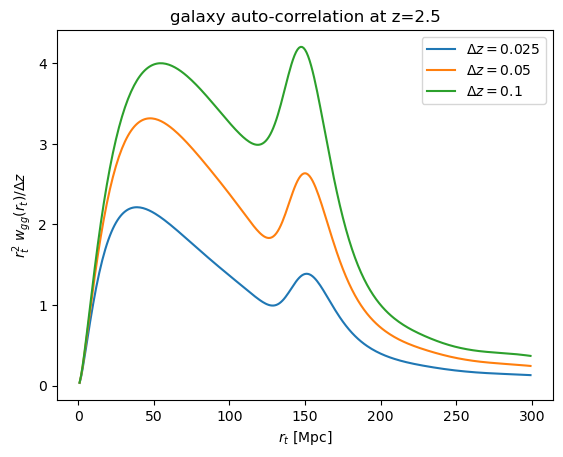

In [17]:
rt = np.arange(1,300,1)
tracer_1='g'
z_c = 2.5
for dz in [0.025, 0.05, 0.1]:
    xi = np.array([xi2d_zc_rt(z_c, dz, r, tracer_1) for r in rt])
    #plt.plot(rt, xi2d_zc_rt(z_c, dz, rt, tracer_1), label=r'$\Delta z={}$'.format(dz))
    plt.plot(rt, rt**2*xi/dz, label=r'$\Delta z={}$'.format(dz))
plt.xlabel(r'$r_t$ [Mpc]')
plt.ylabel(r'$r_t^2 ~ w_{gg}(r_t) / \Delta z$')
plt.legend()
plt.title('galaxy auto-correlation at z={}'.format(z_c))
plt.savefig('w_gg_dz_large_scales.png')

/Users/afont/miniconda3/envs/photoz/lib/python3.13/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


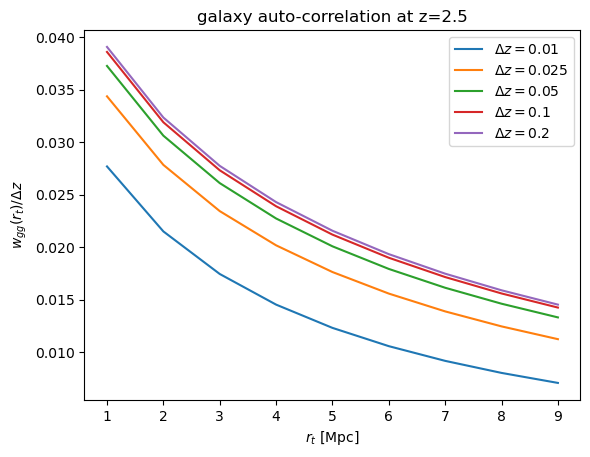

In [18]:
rt = np.arange(1,10,1)
tracer_1='g'
z_c = 2.5
for dz in [0.01, 0.025, 0.05, 0.1, 0.2]:
    xi = np.array([xi2d_zc_rt(z_c, dz, r, tracer_1) for r in rt])
    #plt.plot(rt, xi2d_zc_rt(z_c, dz, rt, tracer_1), label=r'$\Delta z={}$'.format(dz))
    plt.plot(rt, xi/dz, label=r'$\Delta z={}$'.format(dz))
plt.xlabel(r'$r_t$ [Mpc]')
plt.ylabel(r'$w_{gg}(r_t) / \Delta z$')
plt.legend()
plt.title('galaxy auto-correlation at z={}'.format(z_c))
plt.savefig('w_gg_dz_small_scales.png')

While in general the $1/\Delta_z$ scaling is a bad approximation, when dealing with wide bins and very small angular separations, it seems to work well